## Descriptions:
Imputation of missing ESI and HW
- Impute HW using some demographics variables (use 1_2_cohort, more data for HW)
- Impute ESI, either:
    - use 1_3_cohort, with 1st set of VS
    - use cohort after processing labs (1_3_cohort and with LABS, smaller cohort) or the latest
    - compare the missing using 1_3_cohort vs the latest cohort --> ok to use the 1_3_cohort after VS
- One-hot encoding for race and gender
- To be combined with all other vital related information to form the simple dataset

**Inputs**:  
- `2_2_coh2_demoHW` contains all processed variables in demographics (including ESI) and height and weight
- `1_3_cohort` contains the first complete set of vital signs OR
- `cohort3L_withlabs` with only observations who had labs, if use this cohort

**Outputs**: 
- `2_5_coh3_imputedHWESI` 

### Importing R libraries

In [1]:
library(bigrquery)  # to query STARR-OMOP (stored in BigQuery) using SQL
library(tidyverse)
library(lubridate)
library(mice)
library(VIM) # for missing data plot

# library(data.table)
# library(Matrix)
library(caret) # import this before glmnet to avoid rlang version problem
# library(glmnet)
# library(bit64)

# library(slam)
# library(mtools) for one hot coder, not available on Nero or use caret or tidyr
options(repr.matrix.max.rows=250, repr.matrix.max.cols=30)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind


Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attaching package: ‘VIM’


The following object is masked from ‘package:datasets’:

    sleep


Loading required package: lattice



In [3]:
# read inputs
datadir = "../../DataTD"
cohortdir = "../../OutputTD/1_cohort"
featuredir = "../../OutputTD/2_features"

In [3]:
# read inputs
cohort <- read.csv(file.path(cohortdir, "1_3_cohort.csv"))
demo_hw <- read.csv(file.path(featuredir, "2_2_coh2_demoHW.csv"))

# check for unique CSNs and MRNs
nrow(cohort) # 44258
nrow(cohort %>% select(anon_id) %>% distinct()) #30615
nrow(cohort %>% select(pat_enc_csn_id_coded) %>% distinct()) #44258
nrow(cohort %>% select(anon_id, pat_enc_csn_id_coded) %>% distinct()) #44258

nrow(demo_hw) #45794 previous 1_2_cohort
nrow(cohort %>% select(pat_enc_csn_id_coded) %>% distinct()) #44258

colnames(cohort)
colnames(demo_hw)

[1] 44258

[1] 30615

[1] 44258

[1] 44258

[1] 45794

[1] 44258

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "inpatient_data_id_coded" "admit_time"             
 [5] "label"                   "DBP"                    
 [7] "Pulse"                   "RR"                     
 [9] "SBP"                     "Temp"

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "label"                   "admit_time"             
 [5] "inpatient_data_id_coded" "ESI"                    
 [7] "gender"                  "race"                   
 [9] "insurance"               "age"                    
[11] "English"                 "Height"                 
[13] "Weight"

In [4]:
head(cohort, n=1)
head(demo_hw, n=1)

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,DBP,Pulse,RR,SBP,Temp
,<chr>,<dbl>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,JC29f8ad2,131274729058,40679773,2019-08-31 12:52:00+00:00,0,74,95,20,118,36.95


,anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,gender,race,insurance,age,English,Height,Weight
,<chr>,<dbl>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>
1,JC29f8ad2,131274729058,0,2019-08-31 12:52:00,40679773,3,Female,White,1,52,1,165,81


In [5]:
# combined demo_HW with first set of vitals
cohort <- cohort %>% mutate(admit_time = ymd_hms(admit_time))
demo_hw <- demo_hw %>% mutate(admit_time = ymd_hms(admit_time))

cohort_demoHW <- left_join(cohort, demo_hw) # by=c('anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded'))
nrow(cohort_demoHW) # 
nrow(cohort_demoHW %>% select(pat_enc_csn_id_coded) %>% distinct()) #44258
colnames(cohort_demoHW)

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "inpatient_data_id_coded", "admit_time", "label")



[1] 44258

[1] 44258

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "inpatient_data_id_coded" "admit_time"             
 [5] "label"                   "DBP"                    
 [7] "Pulse"                   "RR"                     
 [9] "SBP"                     "Temp"                   
[11] "ESI"                     "gender"                 
[13] "race"                    "insurance"              
[15] "age"                     "English"                
[17] "Height"                  "Weight"

In [6]:
summary(demo_hw %>% select(age, Height, Weight))
summary(cohort_demoHW %>% select(age, Height, Weight))

      age            Height          Weight      
 Min.   :18.00   Min.   :115.0   Min.   : 20.50  
 1st Qu.:44.00   1st Qu.:160.0   1st Qu.: 61.00  
 Median :60.00   Median :168.0   Median : 73.30  
 Mean   :58.28   Mean   :168.2   Mean   : 76.92  
 3rd Qu.:73.00   3rd Qu.:175.3   3rd Qu.: 88.00  
 Max.   :90.00   Max.   :213.0   Max.   :320.69  
                 NA's   :1424    NA's   :312     

      age            Height          Weight      
 Min.   :18.00   Min.   :115.0   Min.   : 20.50  
 1st Qu.:44.00   1st Qu.:160.0   1st Qu.: 61.00  
 Median :60.00   Median :168.0   Median : 73.10  
 Mean   :58.24   Mean   :168.1   Mean   : 76.87  
 3rd Qu.:73.00   3rd Qu.:175.3   3rd Qu.: 88.00  
 Max.   :90.00   Max.   :213.0   Max.   :320.69  
                 NA's   :1362    NA's   :297     

### Imputation for Height and Weight 
- Using just the demographics' variables: gender, race, age, insurance, Height, Weight
- Output: keep imputed height and weight, and add indicators for missingness
- Could use mice, however, simpler approach just use pmm method for 1 single imputation
- Use m=10 (m=5 is ok) as dataset is large and we end up only get 1 imputed dataset
- https://statisticalhorizons.com/predictive-mean-matching, how many cases (k) should be in each match set. Morris et al. (2014) recommended k=10 for most situations. But a lot depends on sample size. With large samples, k=10 is probably the better choice.

,gender,race,age,insurance,Weight,Height,
44334,1,1,1,1,1,1,0
1148,1,1,1,1,1,0,1
36,1,1,1,1,0,1,1
276,1,1,1,1,0,0,2
,0,0,0,0,312,1424,1736



 iter imp variable
  1   1  Height  Weight
  1   2  Height  Weight
  1   3  Height  Weight
  2   1  Height  Weight
  2   2  Height  Weight
  2   3  Height  Weight
  3   1  Height  Weight
  3   2  Height  Weight
  3   3  Height  Weight
  4   1  Height  Weight
  4   2  Height  Weight
  4   3  Height  Weight
  5   1  Height  Weight
  5   2  Height  Weight
  5   3  Height  Weight
  6   1  Height  Weight
  6   2  Height  Weight
  6   3  Height  Weight
  7   1  Height  Weight
  7   2  Height  Weight
  7   3  Height  Weight
  8   1  Height  Weight
  8   2  Height  Weight
  8   3  Height  Weight
  9   1  Height  Weight
  9   2  Height  Weight
  9   3  Height  Weight
  10   1  Height  Weight
  10   2  Height  Weight
  10   3  Height  Weight
  11   1  Height  Weight
  11   2  Height  Weight
  11   3  Height  Weight
  12   1  Height  Weight
  12   2  Height  Weight
  12   3  Height  Weight
  13   1  Height  Weight
  13   2  Height  Weight
  13   3  Height  Weight
  14   1  Height  Weight
  14   

Warning message:
“Number of logged events: 2”


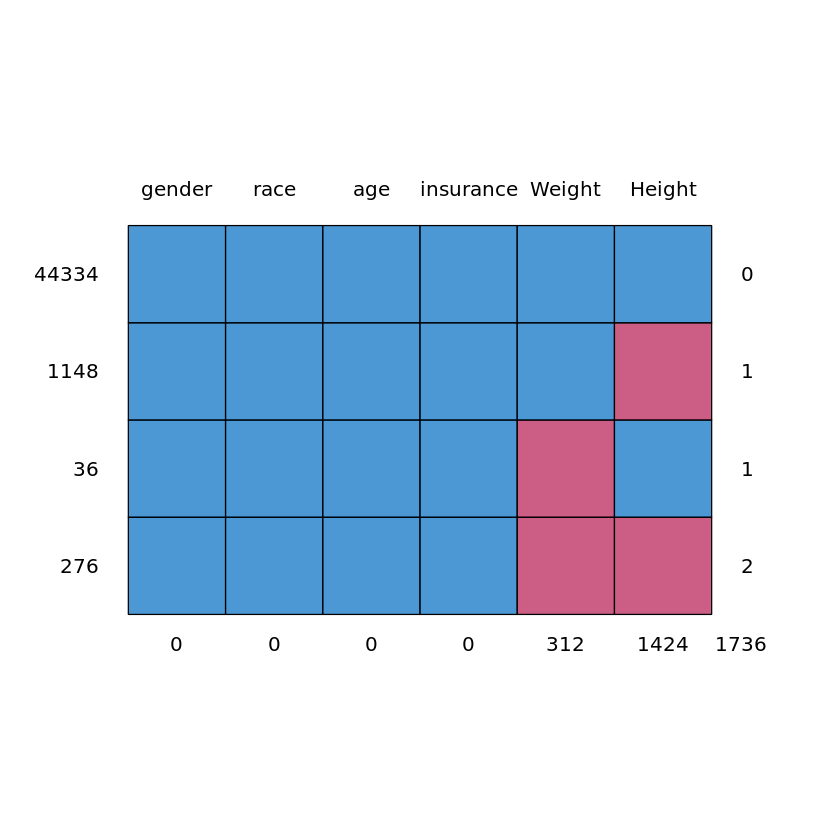

In [7]:
# this takes awhile(~2min), set seed = 123
# only impute 3 time, predictive mean matching with k=10

hw <- demo_hw %>% select(gender, race, age, insurance, Height, Weight)

md.pattern(hw)
hw_mice <- mice(hw, m=3, donors=10, maxit=50, meth='pmm', seed=123)

Warning message in plot.aggr(res, ...):
“not enough horizontal space to display frequencies”



 Variables sorted by number of missings: 
                Variable      Count
                     ESI 0.04063851
                  Height 0.03109578
                  Weight 0.00681312
                 anon_id 0.00000000
    pat_enc_csn_id_coded 0.00000000
                   label 0.00000000
              admit_time 0.00000000
 inpatient_data_id_coded 0.00000000
                  gender 0.00000000
                    race 0.00000000
               insurance 0.00000000
                     age 0.00000000
                 English 0.00000000


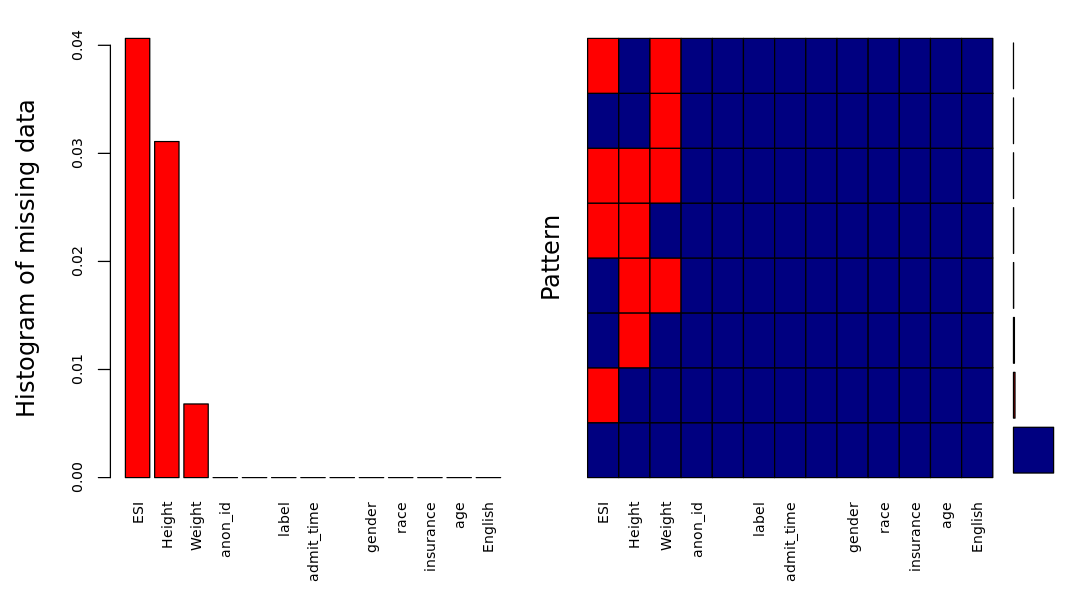

In [8]:
options(repr.plot.width=9, repr.plot.height=5)
aggr_plot <- aggr(demo_hw, col=c('navyblue','red'), numbers=TRUE, sortVars=TRUE, 
                  labels=names(demo_hw), cex.axis=.7, gap=3, ylab=c("Histogram of missing data","Pattern"))

In [9]:
# note: no pooling of results from analysis of multiply imputed dataset
# chose the 2nd set. can also do a random number each time

hw_mice2 <- complete(hw_mice, 2)
summary(hw_mice2)
colnames(hw_mice2)

    gender              race                age          insurance     
 Length:45794       Length:45794       Min.   :18.00   Min.   :0.0000  
 Class :character   Class :character   1st Qu.:44.00   1st Qu.:0.0000  
 Mode  :character   Mode  :character   Median :60.00   Median :0.0000  
                                       Mean   :58.28   Mean   :0.4192  
                                       3rd Qu.:73.00   3rd Qu.:1.0000  
                                       Max.   :90.00   Max.   :1.0000  
     Height          Weight      
 Min.   :115.0   Min.   : 20.50  
 1st Qu.:160.0   1st Qu.: 61.00  
 Median :168.0   Median : 73.39  
 Mean   :168.2   Mean   : 76.95  
 3rd Qu.:175.3   3rd Qu.: 88.00  
 Max.   :213.0   Max.   :320.69  

[1] "gender"    "race"      "age"       "insurance" "Height"    "Weight"

In [10]:
nrow(hw_mice2) #45796

# here: keep bind the old set with the imputed set, just to compare
hw_mice2 <- hw_mice2 %>% select(Height, Weight) %>% 
                    rename(Height_i = Height, Weight_i = Weight)

hw_imputed <- bind_cols(demo_hw, hw_mice2) 
colnames(hw_imputed)

[1] 45794

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "label"                   "admit_time"             
 [5] "inpatient_data_id_coded" "ESI"                    
 [7] "gender"                  "race"                   
 [9] "insurance"               "age"                    
[11] "English"                 "Height"                 
[13] "Weight"                  "Height_i"               
[15] "Weight_i"

In [11]:
head(hw_imputed, n=1)

,anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,gender,race,insurance,age,English,Height,Weight,Height_i,Weight_i
,<chr>,<dbl>,<int>,<dttm>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,JC29f8ad2,131274729058,0,2019-08-31 12:52:00,40679773,3,Female,White,1,52,1,165,81,165,81


In [12]:
# 2 = we have both the original values and the imputed values in this same dataset, 
# but it doesn't have the indicators of missingness
hw_imputed <- hw_imputed %>% 
                select(c(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, label, admit_time, ESI, 
                         gender, race, age, insurance, English, Height, Height_i, Weight, Weight_i)) %>% 
                mutate(delta_H = ifelse(is.na(Height), 1, 0),
                       delta_W = ifelse(is.na(Weight), 1, 0)) %>%
                select(-c(Height, Weight))
summary(hw_imputed %>% select(delta_H, delta_W))
colnames(hw_imputed)

    delta_H          delta_W        
 Min.   :0.0000   Min.   :0.000000  
 1st Qu.:0.0000   1st Qu.:0.000000  
 Median :0.0000   Median :0.000000  
 Mean   :0.0311   Mean   :0.006813  
 3rd Qu.:0.0000   3rd Qu.:0.000000  
 Max.   :1.0000   Max.   :1.000000  

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "inpatient_data_id_coded" "label"                  
 [5] "admit_time"              "ESI"                    
 [7] "gender"                  "race"                   
 [9] "age"                     "insurance"              
[11] "English"                 "Height_i"               
[13] "Weight_i"                "delta_H"                
[15] "delta_W"

In [13]:
cohort_demoHW <- left_join(cohort, hw_imputed) # by=c('anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded'))
nrow(cohort_demoHW) # 44258
nrow(cohort_demoHW %>% select(pat_enc_csn_id_coded) %>% distinct()) #44258
colnames(cohort_demoHW)

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "inpatient_data_id_coded", "admit_time", "label")



[1] 44258

[1] 44258

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "inpatient_data_id_coded" "admit_time"             
 [5] "label"                   "DBP"                    
 [7] "Pulse"                   "RR"                     
 [9] "SBP"                     "Temp"                   
[11] "ESI"                     "gender"                 
[13] "race"                    "age"                    
[15] "insurance"               "English"                
[17] "Height_i"                "Weight_i"               
[19] "delta_H"                 "delta_W"

### Imputation for ESI
ESI -- from acuity_level encounter table
- use first vital values from vitals_clean to impute ESI
- this require the vitals_clean dataset to be done
- cohort with a complete set of vs: 1_3_cohort has the 1st completed vs set

[1] 44258

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   1.00    2.00    3.00    2.66    3.00    5.00    1718 

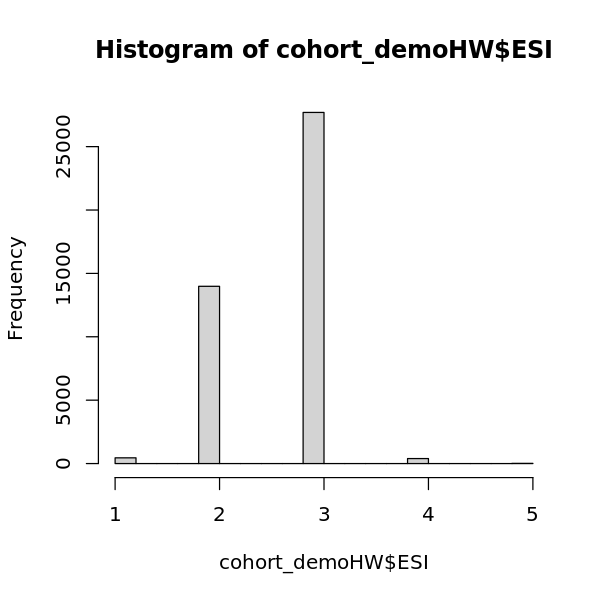

In [14]:
# missing ESI: 1718 (3.88%)
options(repr.plot.width=5, repr.plot.height=5)

nrow(cohort_demoHW) #44258
summary(cohort_demoHW$ESI)
hist(cohort_demoHW$ESI)

In [15]:
# missing ESI per label
cohort_demoHW %>% group_by(ESI, label) %>% count() %>% group_by(ESI) %>% mutate(p = round(100* n/sum(n), 2))

ESI,label,n,p
<int>,<int>,<int>,<dbl>
1,0,108,23.89
1,1,344,76.11
2,0,11087,79.30
2,1,2894,20.70
3,0,25785,93.10
3,1,1912,6.90
4,0,357,90.38
4,1,38,9.62
5,0,14,93.33


,gender,race,age,insurance,Height_i,Weight_i,SBP,DBP,Pulse,RR,Temp,ESI,
42540,1,1,1,1,1,1,1,1,1,1,1,1,0
1718,1,1,1,1,1,1,1,1,1,1,1,0,1
,0,0,0,0,0,0,0,0,0,0,0,1718,1718



 iter imp variable
  1   1  ESI
  1   2  ESI
  1   3  ESI
  2   1  ESI
  2   2  ESI
  2   3  ESI
  3   1  ESI
  3   2  ESI
  3   3  ESI
  4   1  ESI
  4   2  ESI
  4   3  ESI
  5   1  ESI
  5   2  ESI
  5   3  ESI
  6   1  ESI
  6   2  ESI
  6   3  ESI
  7   1  ESI
  7   2  ESI
  7   3  ESI
  8   1  ESI
  8   2  ESI
  8   3  ESI
  9   1  ESI
  9   2  ESI
  9   3  ESI
  10   1  ESI
  10   2  ESI
  10   3  ESI
  11   1  ESI
  11   2  ESI
  11   3  ESI
  12   1  ESI
  12   2  ESI
  12   3  ESI
  13   1  ESI
  13   2  ESI
  13   3  ESI
  14   1  ESI
  14   2  ESI
  14   3  ESI
  15   1  ESI
  15   2  ESI
  15   3  ESI
  16   1  ESI
  16   2  ESI
  16   3  ESI
  17   1  ESI
  17   2  ESI
  17   3  ESI
  18   1  ESI
  18   2  ESI
  18   3  ESI
  19   1  ESI
  19   2  ESI
  19   3  ESI
  20   1  ESI
  20   2  ESI
  20   3  ESI
  21   1  ESI
  21   2  ESI
  21   3  ESI
  22   1  ESI
  22   2  ESI
  22   3  ESI
  23   1  ESI
  23   2  ESI
  23   3  ESI
  24   1  ESI
  24   2  ESI
  24   3  ESI

Warning message:
“Number of logged events: 2”


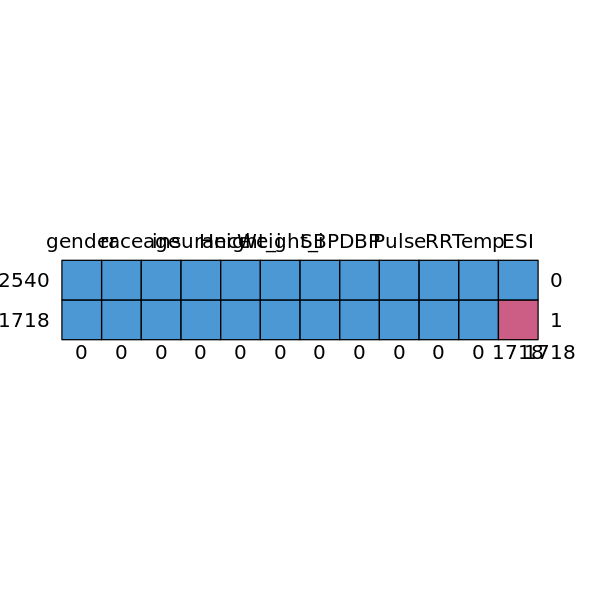

In [16]:
# m = 5 is the default --> takes too long
# meth='pmm' refers to the imputation method, predictive mean matching
# complete(, returns the 2nd completed data set)

esi <- cohort_demoHW %>% select(ESI, gender, race, age, insurance, Height_i, Weight_i, SBP, DBP, Pulse, RR, Temp)
md.pattern(esi)
esi_mice <- mice(esi, m=3, donors=10, maxit=50, meth='pmm', seed=123)

In [17]:
esi_mice2 <- complete(esi_mice, 2)
summary(esi_mice2)
colnames(esi_mice2)

      ESI           gender              race                age       
 Min.   :1.000   Length:44258       Length:44258       Min.   :18.00  
 1st Qu.:2.000   Class :character   Class :character   1st Qu.:44.00  
 Median :3.000   Mode  :character   Mode  :character   Median :60.00  
 Mean   :2.659                                         Mean   :58.24  
 3rd Qu.:3.000                                         3rd Qu.:73.00  
 Max.   :5.000                                         Max.   :90.00  
   insurance         Height_i        Weight_i          SBP       
 Min.   :0.0000   Min.   :115.0   Min.   : 20.5   Min.   : 37.0  
 1st Qu.:0.0000   1st Qu.:160.0   1st Qu.: 61.0   1st Qu.:116.0  
 Median :0.0000   Median :168.0   Median : 73.2   Median :131.0  
 Mean   :0.4197   Mean   :168.2   Mean   : 76.9   Mean   :132.9  
 3rd Qu.:1.0000   3rd Qu.:175.3   3rd Qu.: 88.0   3rd Qu.:148.0  
 Max.   :1.0000   Max.   :213.0   Max.   :320.7   Max.   :419.0  
      DBP             Pulse              

[1] "ESI"       "gender"    "race"      "age"       "insurance" "Height_i" 
 [7] "Weight_i"  "SBP"       "DBP"       "Pulse"     "RR"        "Temp"

In [18]:
colnames(cohort_demoHW)

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "inpatient_data_id_coded" "admit_time"             
 [5] "label"                   "DBP"                    
 [7] "Pulse"                   "RR"                     
 [9] "SBP"                     "Temp"                   
[11] "ESI"                     "gender"                 
[13] "race"                    "age"                    
[15] "insurance"               "English"                
[17] "Height_i"                "Weight_i"               
[19] "delta_H"                 "delta_W"

In [19]:
nrow(esi_mice2) #45796

# here: keep bind the old set with the imputed set, just to compare
esi_mice2 <- esi_mice2 %>% select(ESI_i=ESI)

esi_imputed <- bind_cols(cohort_demoHW, esi_mice2) %>% mutate(delta_ESI = ifelse(is.na(ESI), 1, 0))
colnames(esi_imputed)

[1] 44258

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "inpatient_data_id_coded" "admit_time"             
 [5] "label"                   "DBP"                    
 [7] "Pulse"                   "RR"                     
 [9] "SBP"                     "Temp"                   
[11] "ESI"                     "gender"                 
[13] "race"                    "age"                    
[15] "insurance"               "English"                
[17] "Height_i"                "Weight_i"               
[19] "delta_H"                 "delta_W"                
[21] "ESI_i"                   "delta_ESI"

In [20]:
# rearrange all the columns 
cohort_imp <-  esi_imputed %>% select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, admit_time, label,
                                      ESI_i, delta_ESI, gender, race, age, insurance, English,  
                                      Height_i, delta_H, Weight_i, delta_W)
dim(cohort_imp)
summary(cohort_imp %>% select(ESI_i, delta_ESI, Height_i, delta_H, Weight_i, delta_W))

[1] 44258    16

     ESI_i         delta_ESI          Height_i        delta_H       
 Min.   :1.000   Min.   :0.00000   Min.   :115.0   Min.   :0.00000  
 1st Qu.:2.000   1st Qu.:0.00000   1st Qu.:160.0   1st Qu.:0.00000  
 Median :3.000   Median :0.00000   Median :168.0   Median :0.00000  
 Mean   :2.659   Mean   :0.03882   Mean   :168.2   Mean   :0.03077  
 3rd Qu.:3.000   3rd Qu.:0.00000   3rd Qu.:175.3   3rd Qu.:0.00000  
 Max.   :5.000   Max.   :1.00000   Max.   :213.0   Max.   :1.00000  
    Weight_i        delta_W        
 Min.   : 20.5   Min.   :0.000000  
 1st Qu.: 61.0   1st Qu.:0.000000  
 Median : 73.2   Median :0.000000  
 Mean   : 76.9   Mean   :0.006711  
 3rd Qu.: 88.0   3rd Qu.:0.000000  
 Max.   :320.7   Max.   :1.000000  

### One hot coding for gender and race
* Gender: simply 1 for female and 0 for male
* Race: one-hot coding as usual

In [21]:
# 1 for female and 0 for male:
cohort_imp <- cohort_imp %>% mutate(gender = ifelse(gender == "Male", 0, 1),
                                      race =  as.factor(race))

In [22]:
colnames(cohort_imp)

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "inpatient_data_id_coded" "admit_time"             
 [5] "label"                   "ESI_i"                  
 [7] "delta_ESI"               "gender"                 
 [9] "race"                    "age"                    
[11] "insurance"               "English"                
[13] "Height_i"                "delta_H"                
[15] "Weight_i"                "delta_W"

In [23]:
# onehot coding for race: (caret package for dummyVars)
dummy <- dummyVars(~ race, data = cohort_imp) # if more ! gender + race
race_1hot <- data.frame(predict(dummy, newdata = cohort_imp))
cohort_imp <-  cohort_imp %>% select(-race) %>% bind_cols(race_1hot)
dim(cohort_imp)
summary(cohort_imp)

[1] 44258    22

   anon_id          pat_enc_csn_id_coded inpatient_data_id_coded
 Length:44258       Min.   :1.311e+11    Min.   :13616753       
 Class :character   1st Qu.:1.312e+11    1st Qu.:19695277       
 Mode  :character   Median :1.312e+11    Median :27823880       
                    Mean   :1.312e+11    Mean   :28054495       
                    3rd Qu.:1.313e+11    3rd Qu.:34349734       
                    Max.   :1.313e+11    Max.   :48026130       
   admit_time                      label            ESI_i      
 Min.   :2015-01-01 08:24:00   Min.   :0.0000   Min.   :1.000  
 1st Qu.:2016-05-11 00:53:00   1st Qu.:0.0000   1st Qu.:2.000  
 Median :2017-12-23 00:30:30   Median :0.0000   Median :3.000  
 Mean   :2017-10-07 06:16:09   Mean   :0.1345   Mean   :2.659  
 3rd Qu.:2019-02-15 04:37:00   3rd Qu.:0.0000   3rd Qu.:3.000  
 Max.   :2020-03-31 07:00:00   Max.   :1.0000   Max.   :5.000  
   delta_ESI           gender            age          insurance     
 Min.   :0.00000   Min.   :0

In [24]:
head(cohort_imp, n=3)

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,ESI_i,delta_ESI,gender,age,insurance,English,Height_i,delta_H,Weight_i,delta_W,race.Asian,race.Black,race.Native.American,race.Other,race.Pacific.Islander,race.Unknown,race.White
,<chr>,<dbl>,<int>,<dttm>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,JC29f8ad2,131274729058,40679773,2019-08-31 12:52:00,0,3,0,1,52,1,1,165.00,0,81,0,0,0,0,0,0,0,1
2,JC29f8ad3,131278291027,42992239,2019-10-05 23:48:00,0,3,0,1,35,1,1,163.00,1,49,1,1,0,0,0,0,0,0
3,JC29f8b9c,131266787806,36261582,2019-05-05 01:07:00,0,2,0,0,59,0,0,195.58,1,185,1,0,0,0,0,0,1,0


In [25]:
# save file
write.csv(cohort_imp, file.path(featuredir, "2_5_coh3_imputedHWESI.csv"), row.names=FALSE)

### USE the latest cohort to see how many are missing

In [29]:
demo_hw <- read.csv(file.path(featuredir, "2_2_coh2_demoHW.csv"))
nrow(demo_hw) #45794
                    
coh_imp3 <-  read.csv(file.path(featuredir, "2_5_coh3_imputedHWESI.csv"))
nrow(coh_imp3) # 44258

coh_withlabs <- read.csv(file.path(cohortdir, "cohort3L_withlabs.csv")) #41627
nrow(coh_withlabs) #41627

[1] 45794

[1] 44258

[1] 41627

In [32]:
head(demo_hw, 1)
head(coh_imp3, 1)
head(coh_withlabs, 1)

,anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,gender,race,insurance,age,English,Height,Weight
,<chr>,<dbl>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>
1,JC29f8ad2,131274729058,0,2019-08-31 12:52:00,40679773,3,Female,White,1,52,1,165,81


,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,ESI_i,delta_ESI,gender,age,insurance,English,Height_i,delta_H,Weight_i,delta_W,race.Asian,race.Black,race.Native.American,race.Other,race.Pacific.Islander,race.Unknown,race.White
,<chr>,<dbl>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,JC29f8ad2,131274729058,40679773,2019-08-31 12:52:00,0,3,0,1,52,1,1,165,0,81,0,0,0,0,0,0,0,1


,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label
,<chr>,<dbl>,<int>,<chr>,<int>
1,JCe33305,131063880385,13777312,2015-01-04 08:11:00+00:00,0


In [33]:
demo_hw <- demo_hw %>% mutate(admit_time = ymd_hms(admit_time))
coh_imp3 <- coh_imp3 %>% mutate(admit_time = ymd_hms(admit_time))
coh_withlabs <- coh_withlabs %>% mutate(admit_time = ymd_hms(admit_time))

In [47]:
esiL <- left_join(coh_withlabs, demo_hw)
nrow(esiL)
summary(esiL$ESI) # 1639 missing
sum(coh_imp3$delta_ESI)

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "inpatient_data_id_coded", "admit_time", "label")



[1] 41627

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  1.000   2.000   3.000   2.651   3.000   5.000    1639 

[1] 1718

In [46]:
head(esiL, 3)

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label,ESI,gender,race,insurance,age,English,Height,Weight
,<chr>,<dbl>,<int>,<dttm>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>
1,JCe33305,131063880385,13777312,2015-01-04 08:11:00,0,3,Female,Black,1,56,1,163,60
2,JCcd4014,131178061474,18550319,2016-03-16 00:01:00,0,3,Female,Black,1,81,1,163,97
3,JCdbdb3f,131080211867,14791894,2015-03-09 01:31:00,0,3,Female,Asian,0,79,1,155,56


In [50]:
100*sum(coh_imp3$delta_ESI)/nrow(coh_imp3)
100*1639/nrow(coh_withlabs)

[1] 3.881784

[1] 3.937348